# Test the fully parallel propagation of the Rydberg Hamiltonian

This uses our "keep together" distribution method. We only use 2 threads
here, both in splitting the Hamiltonian, and in OMP_NUM_THREADS

In [1]:
from pathlib import Path

In [2]:
import qutip
import numpy as np
import matplotlib.pylab as plt
import scipy.sparse

In [3]:
from src.qdyn.io import read_indexed_matrix
from src.qdyn.model import LevelModel
from src.qdyn.pulse import Pulse
from src.plots import show_spy, plot_population
from src.blocksplitting import split_AB, split_AB_blocks, split_diagonal_hamiltonian, distribute_keep_together
from src.ham import rydberg_hamiltonian

In [4]:
%matplotlib inline

In [5]:
V_per_cm = 1.0 / 5.14220624463189208e09

In [6]:
# 1-based indices of the initial and target states
N_INITIAL = 1423
N_TARGET = 2696
# size of Hilbert space
N_HILBERT = N_TARGET
N_THREADS = 2  # number of cores on the machine

In [7]:
H = rydberg_hamiltonian(
    N_HILBERT,
    'data/ham_drift.dat',
    'data/ham_sig.dat',
    'data/ham_pi.dat',
    F_DC=2.5 * V_per_cm,
    Omega_sigma=Pulse.read('./data/pulse_sig.dat')
)

In [8]:
pulse = Pulse.read('./data/pulse_sig.dat')

In [9]:
psi0 = qutip.ket([N_INITIAL-1], dim=H[0].shape[0])
psi_target = qutip.ket([N_TARGET-1], dim=H[0].shape[0])

In [10]:
A, B = split_AB_blocks(
    H[1][0].data,
    block_info=np.genfromtxt("./data/n_states_red_block.dat", dtype=np.int32),
    n=N_HILBERT,
    as_qobj=True,
)

In [11]:
A_thread_bins = distribute_keep_together(A, N_THREADS)

In [12]:
[sum(op.data.nnz for op in bin) for bin in A_thread_bins]

[22601, 23851]

In [13]:
A_thread_ops = [sum(bin) for bin in A_thread_bins]

In [14]:
B_thread_bins = distribute_keep_together(B, N_THREADS)

In [15]:
[sum(op.data.nnz for op in bin) for bin in B_thread_bins]

[23851, 22601]

In [16]:
B_thread_ops = [sum(bin) for bin in B_thread_bins]

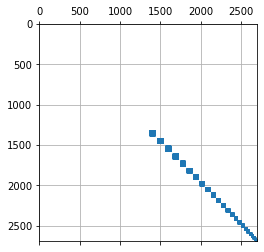

In [18]:
show_spy(A_thread_ops[1].data, show_diagonal=False, grid=True)

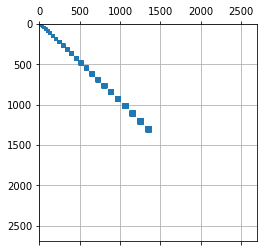

In [19]:
show_spy(B_thread_ops[0].data, show_diagonal=False, grid=True)

In [20]:
qdyn_model = LevelModel()

In [21]:
schedule_fmt = "{row},{col},%s,5" % N_THREADS

In [22]:
for (i, H0) in enumerate(split_diagonal_hamiltonian(H[0], N_THREADS)):
    qdyn_model.add_ham(
        H0,
        op_unit='au',
        op_type='pot',
        schedule=schedule_fmt.format(row=(i + 1), col=1),
    )

In [23]:
for (i, op) in enumerate(A_thread_ops):
    qdyn_model.add_ham(
        op,
        pulse=H[1][1],
        op_unit='au',
        op_type='dip',
        schedule=schedule_fmt.format(row=(i + 1), col=2),
    )

In [24]:
for (i, op) in enumerate(B_thread_ops):
    qdyn_model.add_ham(
        op,
        pulse=H[1][1],
        op_unit='au',
        op_type='dip',
        schedule=schedule_fmt.format(row=(i + 1), col=3),
    )

In [25]:
for (i, op) in enumerate(A_thread_ops):
    qdyn_model.add_ham(
        op.dag(),
        pulse=H[1][1],
        op_unit='au',
        op_type='dip',
        conjg_pulse=True,
        schedule=schedule_fmt.format(row=(i + 1), col=4),
    )

In [26]:
for (i, op) in enumerate(B_thread_ops):
    qdyn_model.add_ham(
        op.dag(),
        pulse=H[1][1],
        op_unit='au',
        op_type='dip',
        conjg_pulse=True,
        schedule=schedule_fmt.format(row=(i + 1), col=5),
    )

In [27]:
qdyn_model.add_state(psi0, label='initial')

In [28]:
qdyn_model.add_state(psi_target, label='target')

In [29]:
qdyn_model.add_observable(
    qutip.ket2dm(psi0),
    'population.dat',
    exp_unit='iu',
    time_unit='ns',
    col_label='initial',
)
qdyn_model.add_observable(
    qutip.ket2dm(psi_target),
    'population.dat',
    exp_unit='iu',
    time_unit='ns',
    col_label='target',
)

In [30]:
qdyn_model.set_propagation(
    T=H[1][1].T,
    nt=len(H[1][1].states_tgrid),
    time_unit=H[1][1].time_unit,
)

In [31]:
RF = './rf_parallel_schedule_keep_together_2threads'

In [32]:
qdyn_model.write_to_runfolder(RF)

In [37]:
%%bash -s "$RF"
qdyn_prop_traj --version
time OMP_NUM_THREADS=2 qdyn_prop_traj --debug --state-label=initial $1

QDYN 2.0dev revision 2b2fa92f1a71e2a8d932a667b7980c5428c8cce7 (rydbergparallel)
  features: no-check-cheby, no-check-newton, parallel-ham=DISJUNCT_COLUMN, use-mkl=false, parallel-oct, backtraces, no-debug, no-no-ipo
  compiled with ifort on Sat Aug 24 05:55:09 2019 on host katamon
***** START OF PROGRAM qdyn_prop_traj ******
Sat Aug 24 20:15:37 +0200 2019

*** Read config file ./rf_parallel_schedule_keep_together_2threads/config ***
*** Done reading config file ***
Set option debug to .true.
Set option state_label to initial
args allocated for  1 arguments
Set arg  1 to ./rf_parallel_schedule_keep_together_2threads                                                                                                                                                                                                                                                                                                                                                                                          

1

real	0m38.393s
user	1m11.827s
sys	0m1.921s


In [38]:
pop_data = np.genfromtxt((Path(RF) / 'population.dat')).transpose()

In [39]:
pop_data_baseline = np.genfromtxt('./rf_baseline/population.dat').transpose()

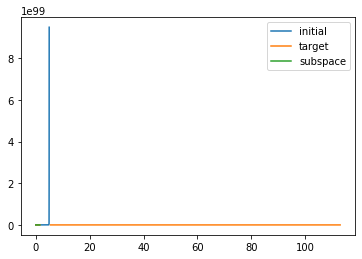

In [40]:
plot_population(pop_data)